In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/model

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/model


In [ ]:
#pip install gdown

In [ ]:
#!gdown --id 1LzHjC2JGzvIlEXZ_LFCLZhN_xNKkP0aR

In [ ]:
#import os
#import zipfile 

#data_dir = './fruitvegs'
#os.mkdir(data_dir)

#with zipfile.ZipFile('fv-fix.zip', 'r') as zip_file:
   #zip_file.extractall(data_dir)

In [ ]:
#import os

#dir = './model'
#os.mkdir(dir)

#os.chdir(dir)

In [ ]:
from tensorflow.keras.utils import image_dataset_from_directory

BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
IMG_SIZE = (IMG_HEIGHT, IMG_WIDTH)
IMG_SHAPE = IMG_SIZE + (3,)

# Edit according to local path for dataset
ds_path = r"fruitvegs"

train_ds = image_dataset_from_directory(ds_path,
                                        validation_split = 0.2,
                                        subset = "training",
                                        seed = 123,
                                        image_size = IMG_SIZE,
                                        batch_size = BATCH_SIZE)

val_ds = image_dataset_from_directory(ds_path,
                                      validation_split = 0.2,
                                      subset = "validation",
                                      seed = 123,
                                      image_size = IMG_SIZE,
                                      batch_size = BATCH_SIZE)

Found 3805 files belonging to 18 classes.
Using 3044 files for training.
Found 3805 files belonging to 18 classes.
Using 761 files for validation.


In [ ]:
class_names = train_ds.class_names
num_classes = len(class_names)

print(class_names)

['f_apple', 'f_banana', 'f_carrot', 'f_greens', 'f_orange', 'f_tomato', 'm_apple', 'm_banana', 'm_carrot', 'm_greens', 'm_orange', 'm_tomato', 'r_apple', 'r_banana', 'r_carrot', 'r_greens', 'r_orange', 'r_tomato']


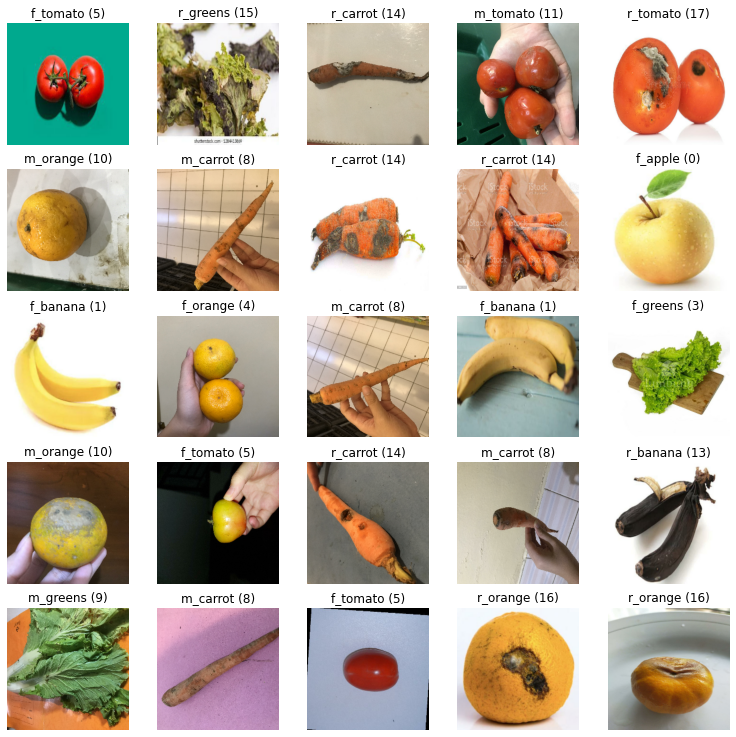

In [ ]:
plt.figure(figsize=(13, 13))
for images, labels in train_ds.take(1):
    for i in range(25):
        ax = plt.subplot(5, 5, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]] + ' ({})'.format(labels[i]))
        plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_dataset = val_ds.take(val_batches // 2)
validation_dataset = val_ds.skip(val_batches // 2)

In [ ]:
# Buffered prefetching
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size = AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size = AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size = AUTOTUNE)

In [ ]:
# Create ResNet50 base model
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions

PRE_TRAINED_MODEL = ResNet50(input_shape = IMG_SHAPE,
                        include_top = False,
                        weights = 'imagenet')

#PRE_TRAINED_MODEL.trainable = False

In [ ]:
PRE_TRAINED_MODEL.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
print("Number of layers: ", len(PRE_TRAINED_MODEL.layers))

Number of layers:  175


In [ ]:
PRE_TRAINED_MODEL.trainable = True

# HYPERPARAMETERS
START_TRAIN = 165
UNITS = 256
DROPOUT = 0.7
LR = 0.0001

# Freeze all the layers before 
for layer in PRE_TRAINED_MODEL.layers[:START_TRAIN]:
    layer.trainable = False
        
# Data augmentation 
AUGMENTATION = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal_and_vertical'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.RandomTranslation(height_factor = (-0.2, 0.2),
                                      width_factor = (-0.2, 0.2),
                                      fill_mode="nearest",
                                      interpolation="bilinear"),
    tf.keras.layers.RandomContrast(0.2)  
])
    
# Add layers
POOLING_LAYER = tf.keras.layers.GlobalAveragePooling2D()
PREDICTION_LAYER = tf.keras.layers.Dense(num_classes, activation='softmax')

# Chain model 
inputs = tf.keras.Input(shape = IMG_SHAPE)
x = AUGMENTATION(inputs) 
x = preprocess_input(x)
x = PRE_TRAINED_MODEL(x, training=False)
x = POOLING_LAYER(x)
x = tf.keras.layers.Dense(UNITS, activation='relu')(x)
x = tf.keras.layers.Dropout(DROPOUT)(x)
outputs = PREDICTION_LAYER(x)
model = tf.keras.Model(inputs,outputs)


In [ ]:
# Display model architecture
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
# Compile model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = LR),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
                metrics=['accuracy'])

In [ ]:
# Callback function
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('val_accuracy')>0.968):
            print("\nReached 96.8% accuracy so cancelling training!")
            self.model.stop_training = True
            
callbacks = myCallback()

In [ ]:
EPOCH = 50

history = model.fit(
            train_dataset,
            validation_data = validation_dataset,
            epochs = EPOCH,
            callbacks=[callbacks]
            )

Epoch 1/50
96/96 [==============================] - 50s 460ms/step - loss: 2.2162 - accuracy: 0.3141 - val_loss: 0.7077 - val_accuracy: 0.7533
Epoch 2/50
96/96 [==============================] - 49s 467ms/step - loss: 0.8999 - accuracy: 0.7129 - val_loss: 0.3535 - val_accuracy: 0.8833
Epoch 3/50
96/96 [==============================] - 46s 453ms/step - loss: 0.6344 - accuracy: 0.7980 - val_loss: 0.2483 - val_accuracy: 0.9072
Epoch 4/50
96/96 [==============================] - 46s 453ms/step - loss: 0.4697 - accuracy: 0.8505 - val_loss: 0.2409 - val_accuracy: 0.9125
Epoch 5/50
96/96 [==============================] - 47s 455ms/step - loss: 0.3972 - accuracy: 0.8765 - val_loss: 0.2536 - val_accuracy: 0.9231
Epoch 6/50
96/96 [==============================] - 47s 455ms/step - loss: 0.3449 - accuracy: 0.8863 - val_loss: 0.2312 - val_accuracy: 0.9390
Epoch 7/50
96/96 [==============================] - 48s 457ms/step - loss: 0.2781 - accuracy: 0.9120 - val_loss: 0.2053 - val_accuracy: 0.9337

## Save Model

In [ ]:
%cd /content/drive/Shareddrives/Capstone/ML/Prediction-Model/model-fix

/content/drive/Shareddrives/Capstone/ML/Prediction-Model/model-fix


In [ ]:
model.save('fruitveg0732.h5')

In [ ]:
tf.saved_model.save(model, 'fruitveg0732')

INFO:tensorflow:Assets written to: fruitveg0732/assets


In [ ]:
model.save('fruitveg0732.pkl')

INFO:tensorflow:Assets written to: fruitveg0732.pkl/assets


In [ ]:
import pickle
pickle.dump(model, open('fruitveg-model.pkl', 'wb'))

INFO:tensorflow:Assets written to: ram://930f00d8-48f1-406f-add4-48fc7282163b/assets


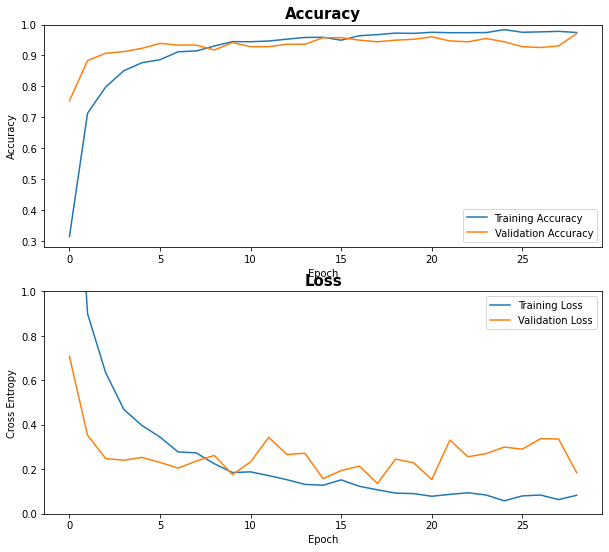

In [ ]:
plt.figure(figsize=(10, 9))

# training and validation accuracy
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.ylim([min(plt.ylim()),1])
plt.title('Accuracy', size=15, fontweight='bold')

# training and validation loss
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.xlabel('Epoch')
plt.ylim([0,1.0])
plt.title('Loss', size=15, fontweight='bold')
plt.show()

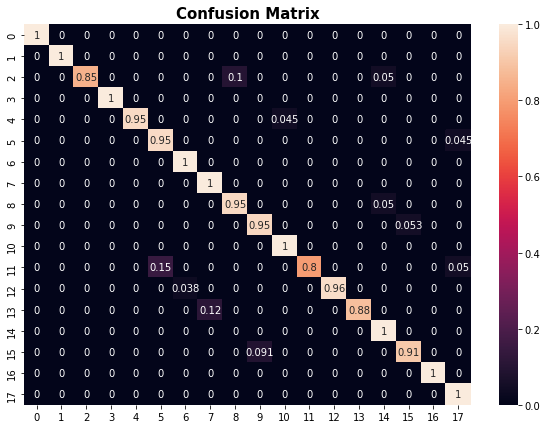

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

predicted = []  # predicted labels
true = []  # true labels

for image_batch, label_batch in test_dataset:  
    true.append(label_batch)
    prediction = model.predict(image_batch)
    predicted.append(np.argmax(prediction, axis=-1))

# convert labels into tensors
true_labels = tf.concat([item for item in true], axis=0)
predicted_labels = tf.concat([item for item in predicted], axis=0)

cf_matrix = confusion_matrix(true_labels, predicted_labels, normalize='true')

# plot confusion  matrix
plt.figure(figsize = (10,7))
sns.heatmap(cf_matrix, 
            annot=True)
plt.title('Confusion Matrix', size=15, fontweight='bold')
plt.show()

## Predict


In [ ]:
# Upload image to be predicted
from ipywidgets import FileUpload

upload = FileUpload()
upload

FileUpload(value={}, description='Upload')

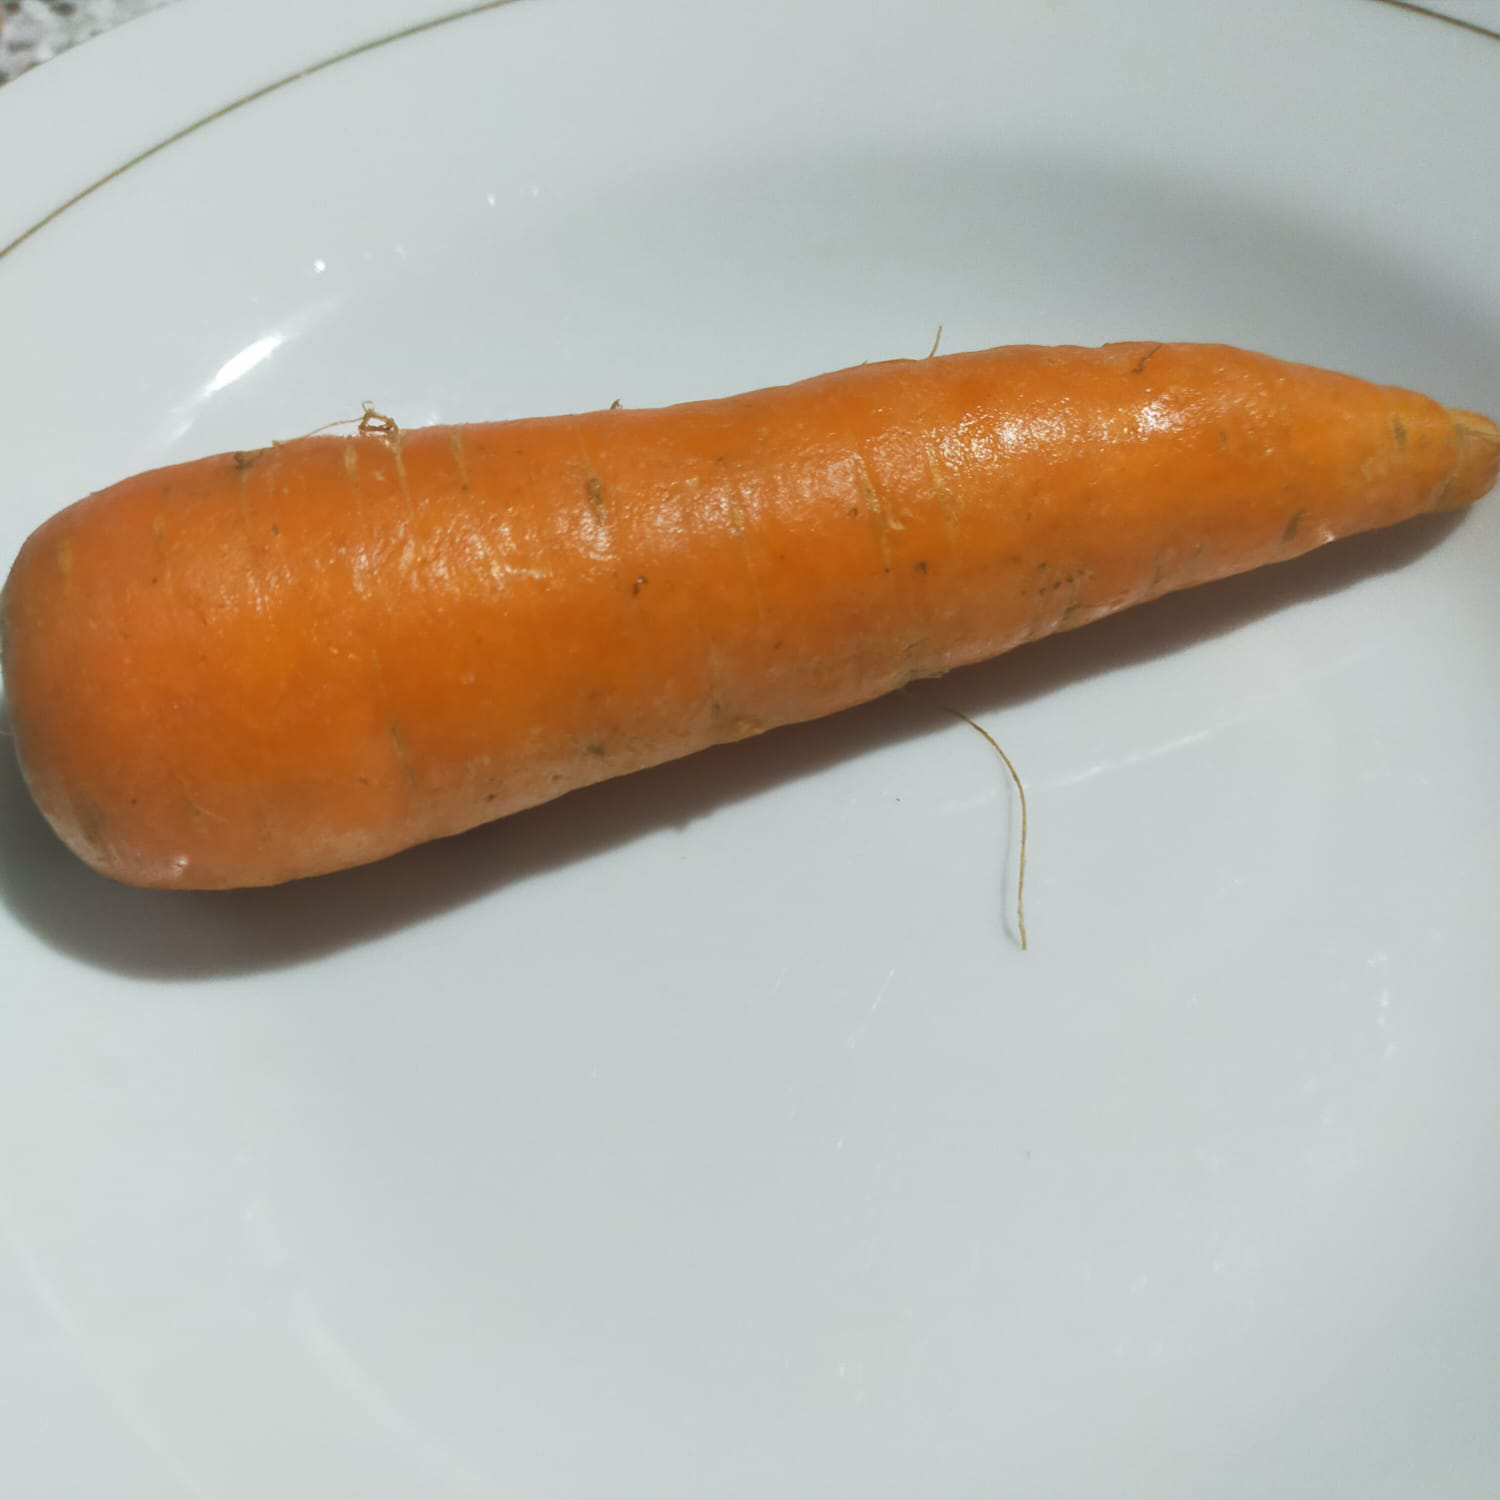

In [ ]:
# Display image
import io
from PIL import Image

for name, file_info in upload.value.items():
    pic = Image.open(io.BytesIO(file_info['content']))

pic

In [ ]:
# Resize image
x = np.array(pic)
x = tf.image.resize(x, [IMG_HEIGHT, IMG_WIDTH])
x = np.expand_dims(x, axis=0)

# Predict image class
pred_img = model.predict(x)
pred_idx = np.argmax(pred_img, axis=-1)

print("It's a {}!".format(class_names[int(pred_idx)]))
print(pred_idx)
print(pred_img)

It's a f_carrot!
[2]
[[7.3559878e-09 4.8129684e-10 9.9989271e-01 1.1775490e-10 1.9296532e-08
  3.6098417e-08 2.0096116e-09 2.8178313e-09 2.7650773e-07 2.5748112e-10
  7.6967595e-08 1.4355692e-09 3.6823117e-11 2.8550631e-09 1.0680162e-04
  1.1850120e-09 5.7662422e-09 8.6947587e-09]]
